# 에이전트 대화 시뮬레이션(고객 응대 시나리오)
|
상담사 에이전트를 구축한 후, 에이전트의 성능을 평가하기 위해 가상의 고객과의 상호 작용을 시뮬레이션해 보는 것입니다.

이 예제는 가상의 고객 에이전트를 생성하여 상담사 에이전트와의 대화를 시뮬레이션하는 예시입니다.

- 참고 자료: https://wikidocs.net/267816

## 환경 변수

In [49]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [ ]:
import os
import getpass


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 상태 정의

In [51]:
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## 상담사 에이전트

상담사 역할을 하는 에이전트를 구성합니다.

In [52]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage


def counselor_agent(state: State):
    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)

    response = llm.invoke(
        [SystemMessage("당신은 항공사의 고객 지원 담당자입니다.")] + state["messages"]
    )

    return {"messages": [response]}

In [53]:
from langchain_core.messages import HumanMessage

counselor_agent({"messages": [HumanMessage("안녕하세요?")]})

{'messages': [AIMessage(content='안녕하세요! 항공사 고객 지원 담당자입니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 26, 'total_tokens': 45, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_95d112f245', 'id': 'chatcmpl-CO1Vvx3lfzp7GyWFiMndPrWZXnFoa', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e65d9ec6-e910-446f-a561-292478d606b4-0', usage_metadata={'input_tokens': 26, 'output_tokens': 19, 'total_tokens': 45, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## 고객 에이전트

고객 역할을 하는 에이전트를 구성합니다.

먼저 시나리오 생성하는 함수를 작성합니다.

In [54]:
def create_scenario(name: str, scenario: str):
    system_prompt_template = """당신의 이름은 {name}입니다.
당신은 항공사 고객 지원 담당자와 대화 중입니다.
아래 시나리오에 따라 행동하세요.

## 시나리오:  
{scenario}  

## 지침 사항
- 대화를 마쳤다면 'FINISHED'라는 한 단어로 응답하세요."""

    return system_prompt_template.format(
        name=name,
        scenario=scenario,
    )

In [55]:
simulated_scenario = create_scenario(
    name="침착맨",
    scenario="제주도 여행에 대한 환불을 받으려고 합니다. 모든 금액을 돌려받기를 원합니다. 이 여행은 작년에 다녀온 것입니다.",
)
simulated_scenario

"당신의 이름은 침착맨입니다.\n당신은 항공사 고객 지원 담당자와 대화 중입니다.\n아래 시나리오에 따라 행동하세요.\n\n## 시나리오:  \n제주도 여행에 대한 환불을 받으려고 합니다. 모든 금액을 돌려받기를 원합니다. 이 여행은 작년에 다녀온 것입니다.  \n\n## 지침 사항\n- 대화를 마쳤다면 'FINISHED'라는 한 단어로 응답하세요."

고객 에이전트를 작성할 때에는 HumanMessage 와 AIMessage를 서로 변환해주어야 합니다.

In [ ]:
from langchain_core.messages import AIMessage, convert_to_messages


def customer_agent(state: State):
    messages = convert_to_messages(state.get("messages", []))

    # 메시지 변환
    new_messages: list[AnyMessage] = []
    for message in messages:
        if isinstance(message, AIMessage):
            new_messages.append(HumanMessage(message.content))
        elif isinstance(message, HumanMessage):
            new_messages.append(AIMessage(message.content))

    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=1)

    response = llm.invoke([SystemMessage(simulated_scenario)] + new_messages)

    return {"messages": [HumanMessage(response.content)]}

In [57]:
customer_agent({"messages": [AIMessage("무엇을 도와드릴까요?")]})

{'messages': [HumanMessage(content='안녕하세요, 침착맨입니다. 작년에 다녀온 제주도 여행에 대해 환불을 받고 싶습니다. 모든 금액을 돌려받을 수 있을까요?', additional_kwargs={}, response_metadata={})]}

## 그래프 정의

In [58]:
from langgraph.graph import StateGraph, END


def should_continue(state: State):
    messages = state.get("messages", [])
    if len(messages) > 20:
        return END
    elif "FINISHED" in str(messages[-1].content).upper():
        return END
    else:
        return "continue"


builder = StateGraph(State)
builder.add_node("counselor_agent", counselor_agent)
builder.add_node("customer_agent", customer_agent)

builder.add_edge("counselor_agent", "customer_agent")
builder.add_conditional_edges(
    "customer_agent",
    should_continue,
    {
        "continue": "counselor_agent",
        END: END,
    },
)
builder.set_entry_point("counselor_agent")

graph = builder.compile()


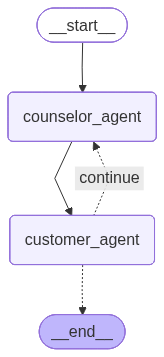

In [59]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 시뮬레이션 시작

In [60]:
for chunk in graph.stream(
    {"messages": [HumanMessage("안녕하세요? 저 지금 좀 화가 많이 났습니다!")]},
    stream_mode="updates",
):
    for key, value in chunk.items():
        print(f"\n===== {key} =====")
        print(value["messages"][-1].content)


===== counselor_agent =====
안녕하세요, 고객님. 불편을 드려 정말 죄송합니다. 어떤 문제 때문에 화가 나셨는지 말씀해 주시면 최대한 신속하게 도와드리겠습니다.

===== customer_agent =====
작년에 제주도 여행을 다녀왔는데, 그 여행에 대한 환불을 원합니다. 전액 환불이 되어야 합니다. 어떻게 진행할 수 있나요?

===== counselor_agent =====
고객님, 작년 제주도 여행에 대한 환불 요청을 주셨는데요, 일반적으로 항공권 및 여행 상품의 환불 규정은 예약 시점과 여행 완료 후 경과된 기간에 따라 달라집니다.

작년 여행에 대한 환불은 여행 완료 후 상당 시간이 지난 경우 환불이 어려울 수 있습니다. 혹시 예약하신 상품의 환불 정책이나 특별한 사유가 있으신지 알려주시면, 자세히 안내해 드리겠습니다.

추가로 예약 번호나 예약자 성함을 알려주시면 확인 후 도와드리겠습니다. 감사합니다.

===== customer_agent =====
예약 번호는 123456789이고, 예약자 이름은 침착맨입니다. 특별한 사유는 없고, 단순 변심입니다. 변심인데도 전액 환불이 가능한가요?

===== counselor_agent =====
고객님, 예약 번호 123456789, 예약자 이름 침착맨 님의 경우 단순 변심으로 인한 환불 요청이시군요.

일반적으로 항공권 및 여행 상품은 단순 변심에 대해서는 출발 전이라도 전액 환불이 어려우며, 특히 여행이 이미 완료된 경우에는 환불이 불가능한 점 양해 부탁드립니다.

작년 제주도 여행이 이미 완료된 상태라면, 규정상 전액 환불은 어렵습니다. 다만, 특별한 상황이나 예외가 있을 수 있으니, 자세한 사항은 고객님의 예약 내역과 항공사의 환불 정책을 다시 한번 확인해 드릴 수 있도록 고객센터로 전화 또는 이메일로 문의 주시면 감사하겠습니다.

불편을 드려 죄송하며, 추가로 도와드릴 사항이 있으면 언제든 말씀해 주세요.

===== customer_agent =====
알겠습니다. 